In [167]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import json
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import GOSTnets as gn
import numpy as np
import datetime
import logging

import itertools
from multiprocessing import Pool, cpu_count


In [189]:
##Logger
logging.root.handlers.clear()
logging.root.handlers

timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
log_filename = f"logs/CuscoEdgesWaze1400_{timestamp}.log"

# logging.basicConfig(
#     level=logging.INFO,
#     datefmt='%Y-%m-%d %H:%M:%S',
# )

logger = logging.getLogger()
logger.setLevel(logging.INFO)

logFormatter = logging.Formatter('%(asctime)s :: %(levelname)s :: %(name)s :: %(process)d :: %(message)s')

# fileHandler = logging.FileHandler(log_filename)
# fileHandler.setFormatter(logFormatter)
# logger.addHandler(fileHandler)

streamHandler = logging.StreamHandler()
streamHandler.setFormatter(logFormatter)
logger.addHandler(streamHandler)
##Logger

In [190]:
logger.info("asdas")

2023-08-17 23:40:03,166 :: INFO :: root :: 26817 :: asdas


# Mapa Cusco

In [111]:
perushape = gpd.read_file("../../Turismo/shapes/peru.shp")
perushape.head()

,iddpto,departamen,idprov,provincia,iddist,distrito,capital,codccpp,area,fuente,geometry
0,01,AMAZONAS,0101,CHACHAPOYAS,010103,BALSAS,BALSAS,0001,1,INEI,"POLYGON ((-77.93289 -6.69210, -77.92945 -6.692..."
1,01,AMAZONAS,0105,LUYA,010515,PROVIDENCIA,PROVIDENCIA,0001,1,INEI,"POLYGON ((-78.29830 -6.27144, -78.29813 -6.271..."
2,01,AMAZONAS,0105,LUYA,010504,COLCAMAR,COLCAMAR,0001,1,INEI,"POLYGON ((-78.03590 -6.27044, -78.03246 -6.270..."
3,01,AMAZONAS,0106,RODRIGUEZ DE MENDOZA,010603,COCHAMAL,COCHAMAL,0001,1,INEI,"POLYGON ((-77.61592 -6.32152, -77.61650 -6.322..."
4,01,AMAZONAS,0105,LUYA,010514,PISUQUIA,YOMBLON,0001,1,INEI,"POLYGON ((-78.04105 -6.39687, -78.04115 -6.397..."


In [112]:
# cuscoshape = perushape[perushape['provincia'].isin(['CUSCO', 'QUISPICANCHI'])]
cuscoshape = perushape[perushape['provincia'].isin(['CUSCO'])]

cuscoshape.head()

,iddpto,departamen,idprov,provincia,iddist,distrito,capital,codccpp,area,fuente,geometry
722,08,CUSCO,0801,CUSCO,080106,SANTIAGO,SANTIAGO,0001,1,INEI,"POLYGON ((-71.98587 -13.52254, -71.98535 -13.5..."
723,08,CUSCO,0801,CUSCO,080108,WANCHAQ,WANCHAQ,0001,1,INEI,"POLYGON ((-71.94640 -13.52731, -71.94352 -13.5..."
761,08,CUSCO,0801,CUSCO,080102,CCORCA,CCORCA,0001,1,INEI,"POLYGON ((-72.06031 -13.52861, -72.05967 -13.5..."
764,08,CUSCO,0801,CUSCO,080105,SAN SEBASTIAN,SAN SEBASTIAN,0001,1,INEI,"POLYGON ((-71.91077 -13.47772, -71.90878 -13.4..."
767,08,CUSCO,0801,CUSCO,080107,SAYLLA,SAYLLA,0001,1,INEI,"POLYGON ((-71.81245 -13.50719, -71.81173 -13.5..."


In [99]:
!ls -l data

total 61564
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7834805 jul 31 23:23 EdgesCusco_wazeinfo.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  6769459 ago  8 21:43 GrafoCusco_edges.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7839841 ago 12 10:45 GrafoCusco_edgeswaze0800.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7835767 ago 13 10:07 GrafoCusco_edgeswaze1400.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7834805 ago  8 21:45 GrafoCusco_edgeswaze.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   730523 ago  8 21:43 GrafoCusco_nodes.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  1086845 ago 17 22:19 GrafoCuscoTransporte_edges.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   168885 ago 17 22:19 GrafoCuscoTransporte_nodes.csv
-rw-r--r-- 1 leibnitz.rojas hadoopgroup  5459968 ago  9 22:44 GrafoCuscoWaze.gpkg
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup 11372052 ago  9 22:29 GrafoCuscoWaze.graphml
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  1694626 may 24 21:53 RutasCusco.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgro

# Loading Nodes and Edges

In [435]:
!ls data

AmenitiesGrafoCusco.csv       GrafoCuscoTransporte_edges.csv
AmenitiesGrafoTransporte.csv  GrafoCuscoTransporte_nodes.csv
CuscoMinValues2Amenities.csv  RutasCusco.csv
EdgesCusco_wazeinfo.csv       RutasCusco_snap_CuscoNodes.csv
GrafoCusco_edges.csv	      wazeresults_bank.csv
GrafoCusco_edgeswaze0800.csv  wazeresults_courthouse.csv
GrafoCusco_edgeswaze1400.csv  wazeresults_hospital.csv
GrafoCusco_edgeswaze.csv      wazeresults_police.csv
GrafoCusco_edgeswaze.zip      wazeresults_school.csv
GrafoCusco_nodes.csv	      wazeresults_university.csv
GrafoCusco_nodes.zip


In [439]:
nodes = pd.read_csv("data/GrafoCusco_nodes.csv", index_col=[0])
# nodes = pd.read_csv("data/GrafoCuscoTransporte_nodes.csv", index_col=[0])

nodes['geometry'] = nodes['geometry'].apply(wkt.loads)
nodes = gpd.GeoDataFrame(nodes, crs='epsg:4326')
# nodes

In [440]:
nodes.shape

(10195, 5)

In [438]:
nodes.shape

(2363, 5)

In [436]:
%%time
edges = pd.read_csv("data/GrafoCusco_edgeswaze.csv", index_col=[0,1,2])
# edges = pd.read_csv("data/GrafoCuscoTransporte_edges.csv", index_col=[0,1,2])

edges['geometry'] = edges['geometry'].apply(wkt.loads)
edges = gpd.GeoDataFrame(edges, crs='epsg:4326')

# cond = edges['wazeinfo_km'] == -1
# edges.loc[cond,'wazeinfo_minutes'] = np.nan
# edges.loc[cond,'wazeinfo_km'] = np.nan
# edges.loc[cond,'wazeinfo'] = np.nan
cols = ['wazeinfo0800_minutes', 'wazeinfo0800_km', 'wazeinfo1400_minutes', 'wazeinfo1400_km']
edges.loc[ :, cols] = edges[cols].replace({-1:np.nan})
edges.head(3)

CPU times: user 3.85 s, sys: 80.1 ms, total: 3.93 s
Wall time: 3.92 s


osmid  \
u        v          key                                    
30962246 3707257935 0    [885654808, 4818990, 885654806]   
         30962247   0                          893177331   
30962247 3707288540 0                            4819824   

                                           name      highway  oneway   length  \
u        v          key                                                         
30962246 3707257935 0    Avenida Velasco Astete        trunk   False  267.284   
         30962247   0    Avenida Velasco Astete        trunk    True   25.109   
30962247 3707288540 0    José Abelardo Quiñones  residential   False    7.919   

                                                                  geometry  \
u        v          key                                                      
30962246 3707257935 0    LINESTRING (-71.94544 -13.53886, -71.94500 -13...   
         30962247   0    LINESTRING (-71.94544 -13.53886, -71.94561 -13...   
30962247 3707288540 0    LINESTRING (-71.94565 -13.53876, -71.94566 -13...   

                        lanes maxspeed junction  ref access  width bridge  \
u        v          key                                                     
30962246 3707257935 0     NaN      NaN      NaN  NaN    NaN    NaN    NaN   
         30962247   0     NaN      NaN      NaN  NaN    NaN    NaN    NaN   
30962247 3707288540 0     NaN      NaN      NaN  NaN    NaN    NaN    NaN   

                         wazeinfo0800_minutes  wazeinfo0800_km  \
u        v          key                                          
30962246 3707257935 0                0.600000            0.248   
         30962247   0                0.033333            0.018   
30962247 3707288540 0                0.000000            0.001   

                                         wazeinfo0800  \
u        v          key                                 
30962246 3707257935 0                    (0.6, 0.248)   
         30962247   0    (0.03333333333333333, 0.018)   
30962247 3707288540 0                    (0.0, 0.001)   

                                         wazeinfo1400  wazeinfo1400_minutes  \
u        v          key                                                       
30962246 3707257935 0                   (0.65, 0.248)              0.650000   
         30962247   0    (0.03333333333333333, 0.018)              0.033333   
30962247 3707288540 0                    (0.0, 0.001)              0.000000   

                         wazeinfo1400_km  
u        v          key                   
30962246 3707257935 0              0.248  
         30962247   0              0.018  
30962247 3707288540 0              0.001

In [965]:
edges.shape

(27082, 20)

In [434]:
# edges.loc[:, cols]
edges.shape

(4721, 17)

In [441]:
tmp = edges[['wazeinfo0800_minutes', 'wazeinfo0800_km']].replace({-1:np.nan})
cond = tmp['wazeinfo0800_km'] == -1
# cond = edges['wazeinfo_km'].isna()
tmp.loc[cond,:]

,,,wazeinfo0800_minutes,wazeinfo0800_km
u,v,key,,


In [812]:
edges.loc[:,'tiempoponderado30kmh']=(edges['wazeinfo0800_km']/30)*60
edges.head()

osmid  \
u        v          key                                    
30962246 3707257935 0    [885654808, 4818990, 885654806]   
         30962247   0                          893177331   
30962247 3707288540 0                            4819824   
         30962248   0                          893177331   
         3709406594 0                            4819824   

                                           name      highway  oneway   length  \
u        v          key                                                         
30962246 3707257935 0    Avenida Velasco Astete        trunk   False  267.284   
         30962247   0    Avenida Velasco Astete        trunk    True   25.109   
30962247 3707288540 0    José Abelardo Quiñones  residential   False    7.919   
         30962248   0    Avenida Velasco Astete        trunk    True   71.513   
         3709406594 0    José Abelardo Quiñones  residential   False  165.049   

                                                                  geometry  \
u        v          key                                                      
30962246 3707257935 0    LINESTRING (-71.94544 -13.53886, -71.94500 -13...   
         30962247   0    LINESTRING (-71.94544 -13.53886, -71.94561 -13...   
30962247 3707288540 0    LINESTRING (-71.94565 -13.53876, -71.94566 -13...   
         30962248   0    LINESTRING (-71.94565 -13.53876, -71.94629 -13...   
         3709406594 0    LINESTRING (-71.94565 -13.53876, -71.94564 -13...   

                        lanes maxspeed junction  ref access  width bridge  \
u        v          key                                                     
30962246 3707257935 0     NaN      NaN      NaN  NaN    NaN    NaN    NaN   
         30962247   0     NaN      NaN      NaN  NaN    NaN    NaN    NaN   
30962247 3707288540 0     NaN      NaN      NaN  NaN    NaN    NaN    NaN   
         30962248   0     NaN      NaN      NaN  NaN    NaN    NaN    NaN   
         3709406594 0     NaN      NaN      NaN  NaN    NaN    NaN    NaN   

                         wazeinfo0800_minutes  wazeinfo0800_km  \
u        v          key                                          
30962246 3707257935 0                0.600000            0.248   
         30962247   0                0.033333            0.018   
30962247 3707288540 0                0.000000            0.001   
         30962248   0                0.000000            0.000   
         3709406594 0                0.750000            0.163   

                                         wazeinfo0800  \
u        v          key                                 
30962246 3707257935 0                    (0.6, 0.248)   
         30962247   0    (0.03333333333333333, 0.018)   
30962247 3707288540 0                    (0.0, 0.001)   
         30962248   0                      (0.0, 0.0)   
         3709406594 0                   (0.75, 0.163)   

                                         wazeinfo1400  wazeinfo1400_minutes  \
u        v          key                                                       
30962246 3707257935 0                   (0.65, 0.248)              0.650000   
         30962247   0    (0.03333333333333333, 0.018)              0.033333   
30962247 3707288540 0                    (0.0, 0.001)              0.000000   
         30962248   0                      (0.0, 0.0)              0.000000   
         3709406594 0     (0.8833333333333333, 0.163)              0.883333   

                         wazeinfo1400_km  tiempoponderado30kmh  
u        v          key                                         
30962246 3707257935 0              0.248                 0.496  
         30962247   0              0.018                 0.036  
30962247 3707288540 0              0.001                 0.002  
         30962248   0              0.000                 0.000  
         3709406594 0              0.163                 0.326

In [813]:
cond = edges['wazeinfo0800_minutes'] == -1
# cond = edges['wazeinfo_km'].isna()
edges.loc[cond,:].shape

(0, 20)

In [814]:
nodes.shape, edges.shape

((10195, 5), (27082, 20))

In [815]:
%%time
G = ox.graph_from_gdfs(nodes, edges)

CPU times: user 6.02 s, sys: 132 ms, total: 6.15 s
Wall time: 6.15 s


In [446]:
amenities_gtransporte = pd.read_csv("data/AmenitiesGrafoCusco.csv", index_col=[0])
# amenities_gtransporte = pd.read_csv("data/AmenitiesGrafoTransporte.csv", index_col=[0])

amenities_gtransporte['geometry'] = amenities_gtransporte['geometry'].apply(wkt.loads)
amenities_gtransporte = gpd.GeoDataFrame(amenities_gtransporte, crs='epsg:4326')
amenities_gtransporte.head()

,unique_id,element_type,amenity,compressed_air,name,opening_hours,geometry_polygon,check_date,denomination,religion,...,contact:pinterest,contact:youtube,full_name,orientation,ways,type,isPoint,geometry,gtransporte_osmid,gtransporte_dist
osmid,,,,,,,,,,,,,,,,,,,,,
441195928,node/441195928,node,fuel,yes,PRIMAX,Mo-Su 00:00-12:00,POINT (-71.9124867 -13.5333168),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.91249 -13.53332),3241267614,0.000392
441195940,node/441195940,node,fuel,yes,REPSOL,Mo-Sa 00:00-12:00,POINT (-71.91688139999999 -13.5320491),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.91688 -13.53205),441195936,0.000138
444056852,node/444056852,node,toilets,NaN,NaN,NaN,POINT (-71.9893113 -13.5246483),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.98931 -13.52465),444056853,0.000206
444056860,node/444056860,node,toilets,NaN,NaN,NaN,POINT (-71.9868232 -13.5267277),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.98682 -13.52673),30985790,0.000541
444056873,node/444056873,node,place_of_worship,NaN,Iglesia de Nuestra Señora de Belén,NaN,POINT (-71.98132219999999 -13.5272097),2023-08-04,catholic,christian,...,NaN,NaN,NaN,NaN,NaN,NaN,True,POINT (-71.98132 -13.52721),30983330,0.000416


In [445]:
amenities_gtransporte.shape

(2530, 205)

# Processing waze results for amenities

In [940]:
# amenities_gtransporte['amenity'].unique()

In [941]:
var_amenity = 'university'

cond = amenities_gtransporte['amenity'] == var_amenity

nearestnodes2amenities = list(amenities_gtransporte.loc[cond,:]['gtransporte_osmid'].values)
nearestnodes2amenities = list(set(nearestnodes2amenities))
len(nearestnodes2amenities)

13

In [942]:
# fig, ax = plt.subplots(figsize=(15,15))

# # nodes.plot(ax=ax, color='g')
# # edges.plot(ax=ax, color='yellow', alpha=0.5)
# edges.plot(ax=ax)
# # cuscoshape.plot(ax=ax, color='gray', alpha=0.2)
# # rutascuscounique_gnodes.plot(ax=ax) 
# # inputdf.plot(ax=ax, color='red')

# # amenities_cols = ['unique_id', 'osmid', 'element_type', 'amenity', 'name',  'geometry',]
# # amenities.loc[cond, amenities_cols ].head(2)
# amenities_gtransporte.loc[cond, :].plot(ax=ax, color='green', marker='x' , )
# # amenities_gtransporte.loc[[874430122], :].plot(ax=ax, color='black', )

# nodes.loc[nearestnodes2amenities,:].plot(ax=ax, color='red')

# # nodes.loc[nodes2plot,:].plot(ax=ax, color='red')
# nodes.loc[[30965748],:].plot(ax=ax, color='black')
# nodes.loc[[995446222],:].plot(ax=ax, color='cyan')
# # 30965748	995446222

In [943]:
nodes.head(3)

,y,x,street_count,highway,geometry
osmid,,,,,
30962246,-13.538861,-71.945440,3,NaN,POINT (-71.94544 -13.53886)
30962247,-13.538763,-71.945649,4,NaN,POINT (-71.94565 -13.53876)
30962248,-13.538602,-71.946289,3,NaN,POINT (-71.94629 -13.53860)


In [944]:
nodes_source = list(set(nodes.index))
print(len(nodes_source))
nodes_target = nearestnodes2amenities
print(len(nodes_target))

10195
13


In [945]:
nodes_sourcecrosstarget = list(itertools.product(nodes_source, nodes_target))

In [946]:
def shortest_path_transporte(G, node_source, node_target):
    try:
        resdict = {}
        for w in ['wazeinfo0800_minutes', 'wazeinfo0800_km', 
                  'wazeinfo1400_minutes', 'wazeinfo1400_km',
                  'tiempoponderado30kmh'
                 ]:
            res = nx.shortest_path_length(G, 
                                      source=node_source, 
                                      target=node_target, 
                                      weight=w)
            resdict[w] = res
    except Exception as e:
        resdict = {}
    return resdict    

In [947]:
nodes_sourcecrosstarget_df = pd.DataFrame(nodes_sourcecrosstarget, columns=['source', 'target'])
nodes_sourcecrosstarget_df.head(3)

,source,target
0,4427186178,5078140484
1,4427186178,5600850918
2,4427186178,30984870


In [948]:
# shortest_path_transporte(G, 30965748, 30985592 )

In [949]:
# %%time
# nodes_sourcecrosstarget_df.head(20).apply(lambda x: shortest_path_transporte(G, x.source, x.target), axis=1 )

In [950]:
nodes_sourcecrosstarget_df.shape[0] , nodes_sourcecrosstarget_df.shape[0]/40

(132535, 3313.375)

In [951]:
%%time
def process_row(row):
    result = shortest_path_transporte(G, row.source, row.target)
    return result

def split_dataframe(df, chunk_size):
    chunks = [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
    return chunks

def apply_chunk(chunk):
    return chunk.apply(process_row, axis=1)

# Define the chunk size based on your dataset size and available resources
chunk_size = 5000

inputdf = nodes_sourcecrosstarget_df

data_chunks = split_dataframe(inputdf, chunk_size)

# Get the number of available CPU cores
# num_cores = cpu_count()
num_cores = int(inputdf.shape[0]/chunk_size)+1
if num_cores > cpu_count():
    num_cores = cpu_count()
# num_cores = cpu_count()
print(f"Num Cores --> {num_cores}")

# # Create a multiprocessing pool with the number of cores
with Pool(num_cores) as pool:
    logger.info("Multiprocessing started.")
    results = pool.map(apply_chunk, data_chunks)
    logger.info("Multiprocessing completed.")

Num Cores --> 27


2023-10-03 19:32:09,306 :: INFO :: root :: 26817 :: Multiprocessing started.
2023-10-03 19:54:46,690 :: INFO :: root :: 26817 :: Multiprocessing completed.


CPU times: user 3.68 s, sys: 6.53 s, total: 10.2 s
Wall time: 22min 42s


In [952]:
len(results)

27

In [953]:
results_df = pd.DataFrame(pd.concat(results), columns=['dict'])
results_df

,dict
0,"{'wazeinfo0800_minutes': 5.966666666666666, 'w..."
1,"{'wazeinfo0800_minutes': 4.133333333333333, 'w..."
2,"{'wazeinfo0800_minutes': 4.916666666666667, 'w..."
3,"{'wazeinfo0800_minutes': 3.2666666666666666, '..."
4,"{'wazeinfo0800_minutes': 5.916666666666665, 'w..."
...,...
132530,"{'wazeinfo0800_minutes': 1.1500000000000001, '..."
132531,"{'wazeinfo0800_minutes': 3.9000000000000004, '..."
132532,"{'wazeinfo0800_minutes': 3.5666666666666664, '..."
132533,"{'wazeinfo0800_minutes': 6.516666666666667, 'w..."


In [954]:
cond = results_df['dict'].map(len)>0
results_df[cond]

,dict
0,"{'wazeinfo0800_minutes': 5.966666666666666, 'w..."
1,"{'wazeinfo0800_minutes': 4.133333333333333, 'w..."
2,"{'wazeinfo0800_minutes': 4.916666666666667, 'w..."
3,"{'wazeinfo0800_minutes': 3.2666666666666666, '..."
4,"{'wazeinfo0800_minutes': 5.916666666666665, 'w..."
...,...
132530,"{'wazeinfo0800_minutes': 1.1500000000000001, '..."
132531,"{'wazeinfo0800_minutes': 3.9000000000000004, '..."
132532,"{'wazeinfo0800_minutes': 3.5666666666666664, '..."
132533,"{'wazeinfo0800_minutes': 6.516666666666667, 'w..."


In [955]:
# df = nodes_sourcecrosstarget_df.merge(results_df, how='left', left_index=True, right_index=True)
# df
dfdict = nodes_sourcecrosstarget_df.merge(results_df[cond], how='inner', left_index=True, right_index=True)
dfdict.head()

,source,target,dict
0,4427186178,5078140484,"{'wazeinfo0800_minutes': 5.966666666666666, 'w..."
1,4427186178,5600850918,"{'wazeinfo0800_minutes': 4.133333333333333, 'w..."
2,4427186178,30984870,"{'wazeinfo0800_minutes': 4.916666666666667, 'w..."
3,4427186178,2641781927,"{'wazeinfo0800_minutes': 3.2666666666666666, '..."
4,4427186178,10789378343,"{'wazeinfo0800_minutes': 5.916666666666665, 'w..."


In [956]:
print(dfdict.shape)
cond = dfdict['dict'].map(len)>0
dfdict[cond].shape

(132483, 3)


(132483, 3)

In [ ]:
%%time
def process_row(row):
    try:
        index = row.name
        tmp = pd.DataFrame.from_dict(dfdict.loc[index][2], orient='index' ).transpose()
        tmp.index = [index]
    except Exception as e:
        logger.info(f"Error in row: {row.name}")
        tmp=None
    return tmp

def split_dataframe(df, chunk_size):
    chunks = [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
    return chunks

def apply_chunk(chunk):
    return chunk.apply(process_row, axis=1)

# Define the chunk size based on your dataset size and available resources
chunk_size = 10000

inputdf = dfdict

data_chunks = split_dataframe(inputdf, chunk_size)

# Get the number of available CPU cores
# num_cores = cpu_count()
num_cores = int(inputdf.shape[0]/chunk_size)+1
if num_cores > cpu_count():
    num_cores = cpu_count()
# num_cores = cpu_count()
print(f"Num Cores --> {num_cores}")

# # Create a multiprocessing pool with the number of cores
with Pool(num_cores) as pool:
    logger.info("Multiprocessing started.")
    results = pool.map(apply_chunk, data_chunks)
    logger.info("Multiprocessing completed.")


# process_row(dfdict.loc[1])

# dfdict_list = dfdict.apply(process_row, axis=1)

Num Cores --> 14


2023-10-03 19:54:49,982 :: INFO :: root :: 26817 :: Multiprocessing started.


In [958]:
lista_df = []
for serie in results:
    lista_df.append(pd.concat(serie.to_list()))

In [959]:
df2 = pd.concat(lista_df)
df2.head()

,wazeinfo0800_minutes,wazeinfo0800_km,wazeinfo1400_minutes,wazeinfo1400_km,tiempoponderado30kmh
0,5.966667,3.594,5.583333,3.593,7.188
1,4.133333,2.488,4.116667,2.488,4.976
2,4.916667,2.552,4.733333,2.552,5.104
3,3.266667,2.027,3.316667,2.027,4.054
4,5.916667,3.577,5.566667,3.576,7.154


In [960]:
# df.merge(df2, )
df3 = df[['source', 'target']].merge(df2, how='left', left_index=True, right_index=True)
df3

,source,target,wazeinfo0800_minutes,wazeinfo0800_km,wazeinfo1400_minutes,wazeinfo1400_km,tiempoponderado30kmh
0,4427186178,4293677040,5.966667,3.594,5.583333,3.593,7.188
1,4427186178,3738278157,4.133333,2.488,4.116667,2.488,4.976
2,4427186178,1005309702,4.916667,2.552,4.733333,2.552,5.104
3,4477353987,4293677040,3.266667,2.027,3.316667,2.027,4.054
4,4477353987,3738278157,5.916667,3.577,5.566667,3.576,7.154
...,...,...,...,...,...,...,...
30580,10654220284,3738278157,5.566667,2.830,5.366667,2.829,5.660
30581,10654220284,1005309702,5.000000,2.741,4.800000,2.792,5.482
30582,4477353983,4293677040,9.116667,4.575,8.833333,4.574,9.150
30583,4477353983,3738278157,5.266667,2.720,5.050000,2.771,5.440


In [961]:
df3.to_csv(f"data/wazeresultsgrafocusco_{var_amenity}.csv", sep=';', index=False)

In [962]:
!ls -l data

total 125724
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  1186727 set 25 23:04 AmenitiesGrafoCusco.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  1185519 ago 17 22:26 AmenitiesGrafoTransporte.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   138838 ago 31 21:45 CuscoMinValues2Amenities.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7834805 jul 31 23:23 EdgesCusco_wazeinfo.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  6769459 ago  8 21:43 GrafoCusco_edges.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7839841 ago 12 10:45 GrafoCusco_edgeswaze0800.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  7835767 ago 13 10:07 GrafoCusco_edgeswaze1400.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  9093449 ago 23 22:47 GrafoCusco_edgeswaze.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup  1824005 ago 23 22:49 GrafoCusco_edgeswaze.zip
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   730523 ago  8 21:43 GrafoCusco_nodes.csv
-rw-rw-r-- 1 leibnitz.rojas hadoopgroup   181126 ago 23 22:50 GrafoCusco_nodes.zip
-rw-rw-r-- 1 leibnitz.rojas 

In [963]:
pd.read_csv(f"data/wazeresultsgrafocusco_{var_amenity}.csv", sep=';',)

,source,target,wazeinfo0800_minutes,wazeinfo0800_km,wazeinfo1400_minutes,wazeinfo1400_km,tiempoponderado30kmh
0,4427186178,4293677040,5.966667,3.594,5.583333,3.593,7.188
1,4427186178,3738278157,4.133333,2.488,4.116667,2.488,4.976
2,4427186178,1005309702,4.916667,2.552,4.733333,2.552,5.104
3,4477353987,4293677040,3.266667,2.027,3.316667,2.027,4.054
4,4477353987,3738278157,5.916667,3.577,5.566667,3.576,7.154
...,...,...,...,...,...,...,...
30568,10654220284,3738278157,5.566667,2.830,5.366667,2.829,5.660
30569,10654220284,1005309702,5.000000,2.741,4.800000,2.792,5.482
30570,4477353983,4293677040,9.116667,4.575,8.833333,4.574,9.150
30571,4477353983,3738278157,5.266667,2.720,5.050000,2.771,5.440


In [964]:
1

1

In [966]:
edges.head()

osmid  \
u        v          key                                    
30962246 3707257935 0    [885654808, 4818990, 885654806]   
         30962247   0                          893177331   
30962247 3707288540 0                            4819824   
         30962248   0                          893177331   
         3709406594 0                            4819824   

                                           name      highway  oneway   length  \
u        v          key                                                         
30962246 3707257935 0    Avenida Velasco Astete        trunk   False  267.284   
         30962247   0    Avenida Velasco Astete        trunk    True   25.109   
30962247 3707288540 0    José Abelardo Quiñones  residential   False    7.919   
         30962248   0    Avenida Velasco Astete        trunk    True   71.513   
         3709406594 0    José Abelardo Quiñones  residential   False  165.049   

                                                                  geometry  \
u        v          key                                                      
30962246 3707257935 0    LINESTRING (-71.94544 -13.53886, -71.94500 -13...   
         30962247   0    LINESTRING (-71.94544 -13.53886, -71.94561 -13...   
30962247 3707288540 0    LINESTRING (-71.94565 -13.53876, -71.94566 -13...   
         30962248   0    LINESTRING (-71.94565 -13.53876, -71.94629 -13...   
         3709406594 0    LINESTRING (-71.94565 -13.53876, -71.94564 -13...   

                        lanes maxspeed junction  ref access  width bridge  \
u        v          key                                                     
30962246 3707257935 0     NaN      NaN      NaN  NaN    NaN    NaN    NaN   
         30962247   0     NaN      NaN      NaN  NaN    NaN    NaN    NaN   
30962247 3707288540 0     NaN      NaN      NaN  NaN    NaN    NaN    NaN   
         30962248   0     NaN      NaN      NaN  NaN    NaN    NaN    NaN   
         3709406594 0     NaN      NaN      NaN  NaN    NaN    NaN    NaN   

                         wazeinfo0800_minutes  wazeinfo0800_km  \
u        v          key                                          
30962246 3707257935 0                0.600000            0.248   
         30962247   0                0.033333            0.018   
30962247 3707288540 0                0.000000            0.001   
         30962248   0                0.000000            0.000   
         3709406594 0                0.750000            0.163   

                                         wazeinfo0800  \
u        v          key                                 
30962246 3707257935 0                    (0.6, 0.248)   
         30962247   0    (0.03333333333333333, 0.018)   
30962247 3707288540 0                    (0.0, 0.001)   
         30962248   0                      (0.0, 0.0)   
         3709406594 0                   (0.75, 0.163)   

                                         wazeinfo1400  wazeinfo1400_minutes  \
u        v          key                                                       
30962246 3707257935 0                   (0.65, 0.248)              0.650000   
         30962247   0    (0.03333333333333333, 0.018)              0.033333   
30962247 3707288540 0                    (0.0, 0.001)              0.000000   
         30962248   0                      (0.0, 0.0)              0.000000   
         3709406594 0     (0.8833333333333333, 0.163)              0.883333   

                         wazeinfo1400_km  tiempoponderado30kmh  
u        v          key                                         
30962246 3707257935 0              0.248                 0.496  
         30962247   0              0.018                 0.036  
30962247 3707288540 0              0.001                 0.002  
         30962248   0              0.000                 0.000  
         3709406594 0              0.163                 0.326

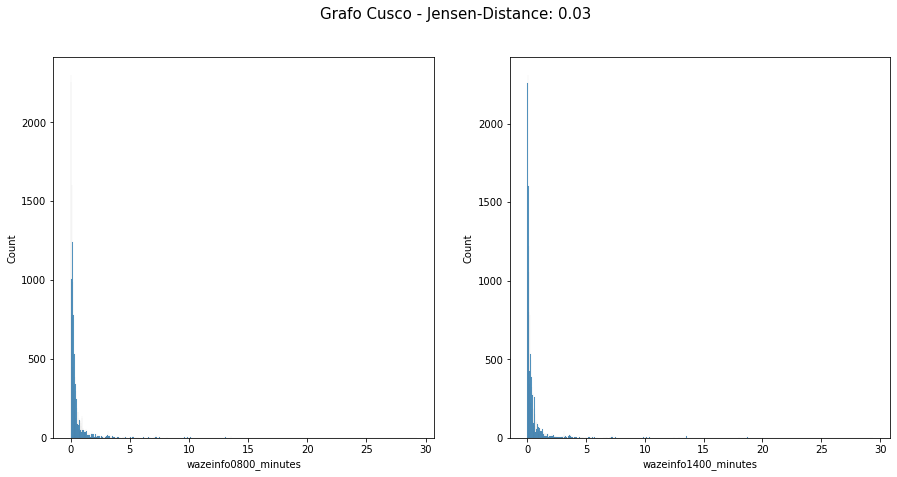

In [984]:
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance

fig, ax = plt.subplots(1,2, figsize=(15,7))

df = edges.query("wazeinfo0800_minutes > 0 & wazeinfo1400_minutes > 0")
# df = edges
bins=50

hist08, bin_edges08 = np.histogram(df['wazeinfo0800_minutes'], density=True, bins=bins)
hist14, bin_edges14 = np.histogram(df['wazeinfo1400_minutes'], density=True, bins=bins)

jensendistance = distance.jensenshannon(hist08, hist14, 2)
# jensen_distances[amenity] = jensendistance

sns.histplot(df, x='wazeinfo0800_minutes',log_scale=False, ax=ax[0])
sns.histplot(df, x='wazeinfo1400_minutes',log_scale=False, ax=ax[1])

fig.suptitle(f'Grafo Cusco - Jensen-Distance: {jensendistance:.2f} ', fontsize=15)
plt.show()
# fig.savefig(f"img/cusco_accessibility_minutes_{amenity}.png")    

<AxesSubplot:>

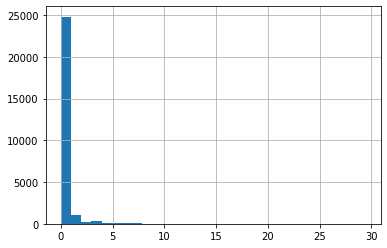

In [969]:
edges['wazeinfo1400_minutes'].hist(bins=30)